# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitsziPS/'

In [3]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec = 30*u.deg, 55*u.deg
axis_q1, axis_q2 = 0.7, 0.7
euler_1, euler_2, euler_3 = 0*u.deg, 90*u.deg, 35*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_seed = 141416 #int(np.random.uniform(0,10000000))

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 18*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 0.5

# Noise
noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_seed = 123141 #None

In [5]:
#----- Analysis parameters
# Image sampling
los_size = 1*u.Mpc
los_reso = 100*u.kpc

# Pk measurement
Nbins_pk = 40
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM.to('arcsec'))

# weight definition
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# methodology
method_data_deconv = False
method_use_covmat  = False
method_parallel    = False

method_setup_overwrite = False

# Generate mock data

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}

mock.map_center = SkyCoord(mock.coord.ra, mock.coord.dec, frame="icrs")
mock.map_fov    = [5, 5]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = los_reso
mock.los_size  = los_size
mock.R_truncation = mock.R500*5

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 59 , 59 , 11
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   1855.0   ,   1855.0   ] kpc ; [   4.917    ,   4.917    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.003390  /  0.098305   1/arcsec
   k min/max projected :       0.000539  /  0.015633   1/kpc
   k min/max L.o.S. (eq.) :    0.005717  /  0.028583   1/arcsec
   k min/max L.o.S. :          0.000909  /  0.004545   1/kpc
   k max Nyquist :             0.028583   1/arcsec
   k max Nyquist :             0.004545   1/kpc


In [7]:
#===== Initiate a data object and fake data
#----- Init with the mock
data = pitszi.Data(mock.get_sz_map(), mock.get_map_header())
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model = [noise_r, noise_k]

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1'], data.header['CRVAL2'])
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
data.mask = mask

#----- Define the PS mask
seed1 = [0,4,6,11, 12]
seed2 = [1,2,3,35, 36]
for i in range(len(seed1)):
    np.random.seed(seed=seed1[i])
    dRA = np.random.uniform(-1,1)*5.0/2/60
    np.random.seed(seed=seed2[i])
    dDec = np.random.uniform(-1,1)*5.0/2/60
    dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1']+dRA, data.header['CRVAL2']+dDec)
    data.mask[dist_map < 18*2/3600] = 0

#----- Define the noise properties
data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data.noise_rms = data.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)

#----- Mock the data
img = data.set_image_to_mock(mock, 
                             model_seed=fluct_seed, model_no_fluctuations=False, 
                             noise_origin='model', noise_center=mock.map_center, noise_seed=noise_seed)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                           Data                             
------------------------------------------------------------


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  


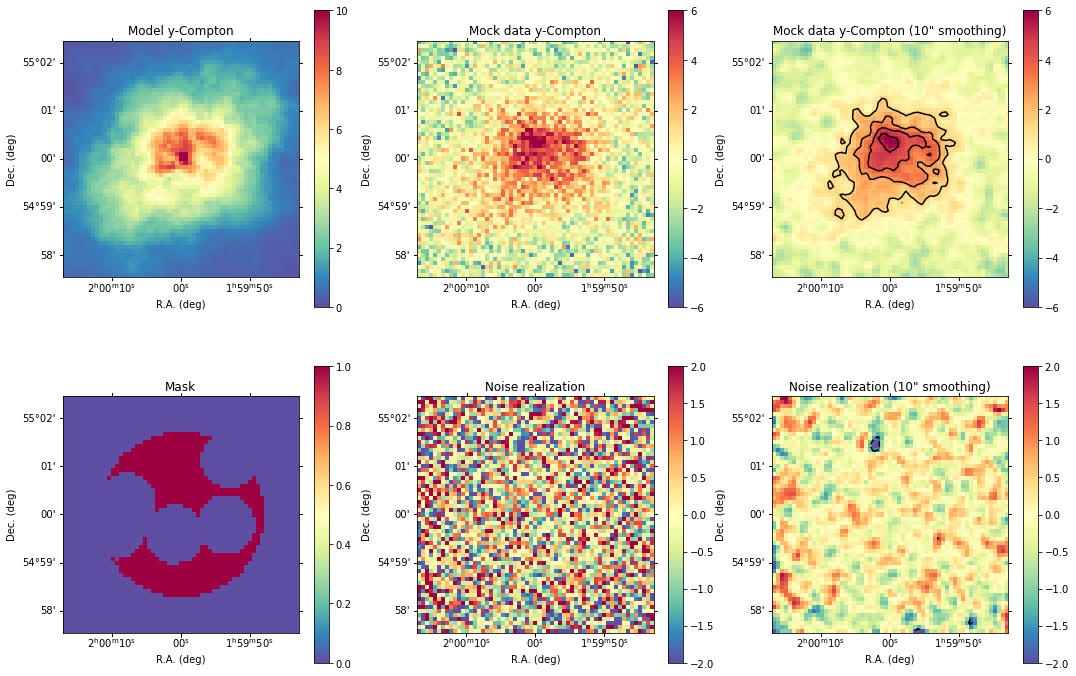

In [8]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(data.noise_mc[0]*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='k')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Inference

In [9]:
model = copy.deepcopy(mock)

In [10]:
inference = pitszi.Inference(data, model, output_dir=output_dir)

inference.kbin_min   = kmin_pk
inference.kbin_max   = kmax_pk
inference.kbin_Nbin  = Nbins_pk
inference.kbin_scale = scale_bins

inference.method_use_covmat  = True
inference.method_parallel    = False
inference.method_data_deconv = False
inference.set_method_w8(apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=method_w8_smooth)
inference.pk_setup()

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                         Inference                          
------------------------------------------------------------
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 4.  4.  4.  8.  4. 12.  8.  4. 12.  8. 20.  8. 12. 20. 16. 16. 16. 16.
 28. 20. 20. 24.  8. 40. 16. 24. 32. 32. 28. 32. 20. 36. 40. 28. 44. 16.
 52. 28. 36. 48.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----


In [11]:
unit = 'kpc'
phys=True

k2d, pk2d_data = inference.get_pk2d_data(physical=phys)
k2d, pk2d_test_modbrute  = inference.get_pk2d_model_brute(physical=phys, seed=1)
k2d, pk2d_test_moddeproj = inference.get_pk2d_model_proj(physical=phys)

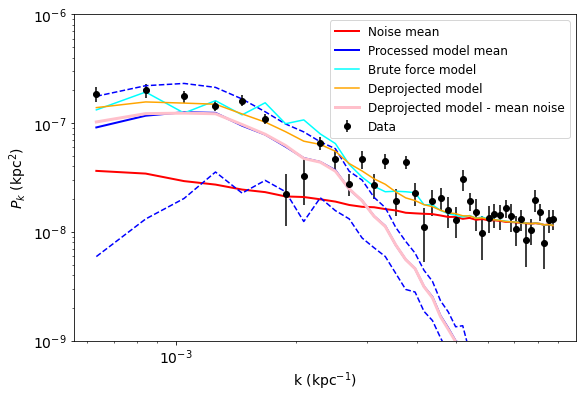

In [12]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 6))

plt.errorbar(k2d.to_value(unit+'-1'), pk2d_data.to_value(unit+'2'), 
             inference._pk2d_noise_rms, marker='o', ls='', color='k', label='Data')
plt.plot(k2d.to_value(unit+'-1'), inference._pk2d_noise, color='red', lw=2, label='Noise mean')
plt.plot(k2d.to_value(unit+'-1'), inference._pk2d_modref, color='blue', lw=2, label='Processed model mean')
plt.plot(k2d.to_value(unit+'-1'), inference._pk2d_modref + inference._pk2d_modref_rms, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), inference._pk2d_modref - inference._pk2d_modref_rms, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_modbrute.to_value(unit+'2'), color='cyan', label='Brute force model')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_moddeproj.to_value(unit+'2'), color='orange', label='Deprojected model')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_moddeproj.to_value(unit+'2')-inference._pk2d_noise, color='pink', lw=3, label='Deprojected model - mean noise')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(np.amax(pk2d_data.to_value(unit+'2'))*5e-3, np.amax(pk2d_data.to_value(unit+'2'))*1.5)
plt.ylim(1e-9,1e-6)
plt.xlabel('k ('+unit+'$^{-1}$)')
plt.ylabel(r'$P_k$ ('+unit+'$^{2}$)')
plt.legend(fontsize=12)

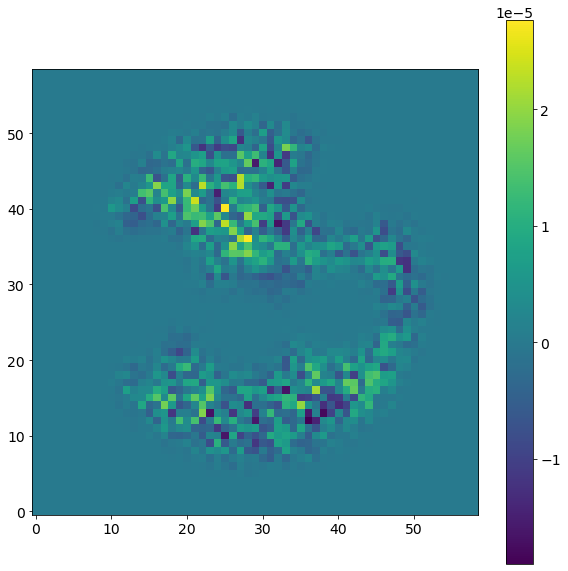

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(inference._dy_image, origin='lower')
plt.colorbar()

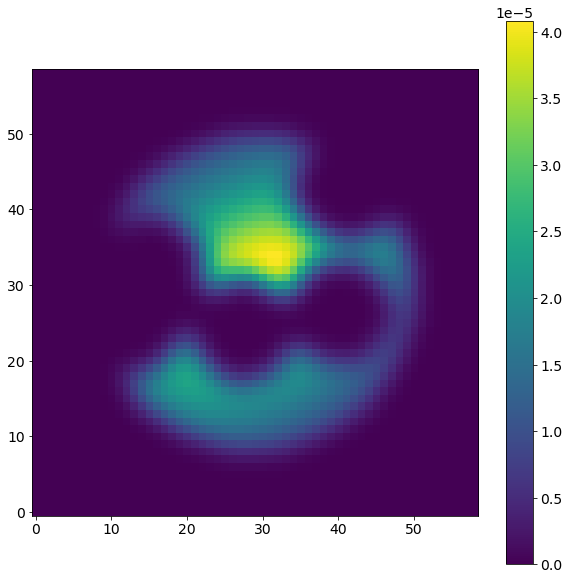

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(inference.method_w8, origin='lower')
plt.colorbar()

In [15]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

In [16]:
inference.method_use_covmat = True
plist, popt, pcov = inference.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done. We can proceed, but still make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.4163404638564522 -0.037658848956860114 +0.03769650951373754
   best-fit = 0.4408122781071043 -0.06213066320751226 +0.013224695263085395
   Norm = 0.4163404638564522_{-0.037658848956860114}^{0.03769650951373754}
param 1 (Linj): 
   median   = 982.1141123096844 -95.8493228453525 +97.74241118187763
   best-fit = 983.5475311831539 -97.28274171882197 +96.30899230840816
   Linj = 982.1141123096844_{-95.8493228453525}^{97.74241118187763}
param 2 (Anoise): 
   median   = 1.09411087689241 -0.1094282731552857 +0.10748318087827413
   best-fit = 1.1600966722609398 -0.17541406852381558 +0.041497385509744245
   Anoise = 1.09411087689241_{-0.1094282731552857}^{0.10748318087827413}
